# Dimensionality Reduction

What is the dimension of geoscientific data?

A low dimensional data space is one that only a few variables/parameters are required to explain the data. A gighly dimensional data space is one that requires a large number of variables/parameters to explain the data.

High dimensional data sets are difficult to manage: they are hard to understand, hard to visualize, hard to store in memory or disk, hard to model. Reducing the dimensionality as a separate pre-processing steps may be advantageous.

Feature *selection* finds the dimensions that explain the data without loss of information and ends with a smaller dimensionality of the input data. A *forward selection* approach starts with one variable that decreases the error the most and add one by one. A *backward selection* starts with all variables and removes them one by one.

Feature *extraction* finds a new set of dimension as a combination of the original dimensions. They can be supervised or unsupervised depending on the output information. Examples are **Principal Component Analysis**, **Independent Component Analysis** **Linear Discriminant Analysis**


## 1. Principal Component Analysis

PCA uses an orthogonal linear transformation to reduce the dimension of the data while maximizing the data variance.

PCA is an unsupervised learning method that finds the mapping from the input to a lower dimensional space with minimum loss of information. 

PCA Uses an orthogonal linear transformation to convert a set of observations to a new coordinate system that maximizes the variance.

The new *coordinates* are the **principal components**.



PCA idenditfies the axis that accounts for the largest amount of variance in the data. Let's  $\mathbf{Y} = \mathbf{y}_1,\cdots,\mathbf{y}_n $ be the data, measured $n$ times over multiple fields of measurements (the length of $\mathbf{y})$. Each **column** of $\mathbf{Y}$ is different measurements for single experiments (e.g., single time stamps). Each column of $ \mathbf{Y} $ is the same measurement repeated over several experiments (or time).  The steps to PCA are:
1. center and standardize the data by substracting mean of each row of $\mathbf{Y} $  (all measurements at a single experiment or time stamp)
2. Calculate the covariance matrix of the de-meaned data $\mathbf{C}  =  \frac{1}{n-1} \mathbf{Y}^{\ast}\mathbf{Y}$. By definition, the covariance matrix is positive symmetric (e.g., $\mathbf{C}^T=\mathbf{C}$) semi-definite, and thus can be diagonalized.
3. Calculate the Singular Value Decomposition (SVD) of the covariance matrix $\mathbf{C} $.


PCA uses the *(Singular Value Decomposition (SVD)* to decompose the data covariance matrix $\mathbf{C} $:

$\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}^T ,$

where $\mathbf{V}^T$ contains the eigenvectors, or principal components. The *PCs* are normalized, centered around zero.

The *1st principal component* eigenvector that has the highest eigenvalue in the direction that has the highest variance.

We will start simple with 10000 data points measured for 2 variables.

In [2]:
# Import useful modules
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as ln
import pandas as pd
from matplotlib import cm
%matplotlib inline
from sklearn.decomposition import PCA

We will start with fake data, a 2D cloud point of 10,000 measurements over 2 variables.

(2, 10000)


(-6.0, 8.0)

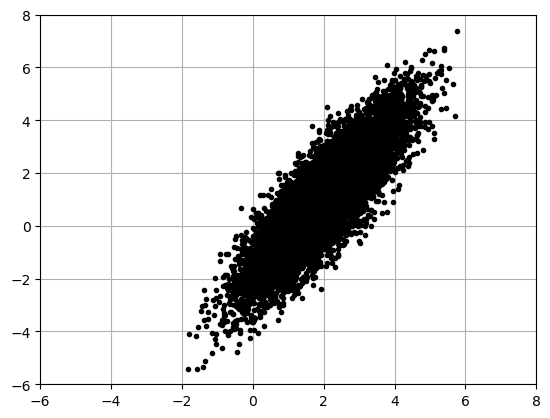

In [4]:
# create fake data
xC = np.array([2, 1])      # Center of data (mean)
sig = np.array([2, 0.5])   # Principal axes
theta = np.pi/3            # Rotate cloud by pi/3
R = np.array([[np.cos(theta), -np.sin(theta)],     # Rotation matrix
              [np.sin(theta), np.cos(theta)]])
nPoints = 10000            # Create 10,000 points

# create the cloud of points by multiplying (np.matmul is also called by @)
X = R @ np.diag(sig) @ np.random.randn(2,nPoints) + np.diag(xC) @ np.ones((2,nPoints))
# print the shape of teh array
print(X.shape)
# plot the data
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(X[0,:],X[1,:], '.', color='k')
ax1.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))

### 1. Substract the mean of the data

In [5]:
## Remove the mean of the data
Xavg = np.mean(X,axis=1)                  # Compute mean
B = X - np.tile(Xavg,(nPoints,1)).T       # Mean-subtracted data
print(B.shape)

(2, 10000)


### 2. SVD of the covariance matrix

In [6]:
# Find principal components (SVD): 
# use the option full_matrices =0 will calculate the covariance of B
U, S, VT = np.linalg.svd(B/np.sqrt(nPoints),full_matrices=0)

Plot the results

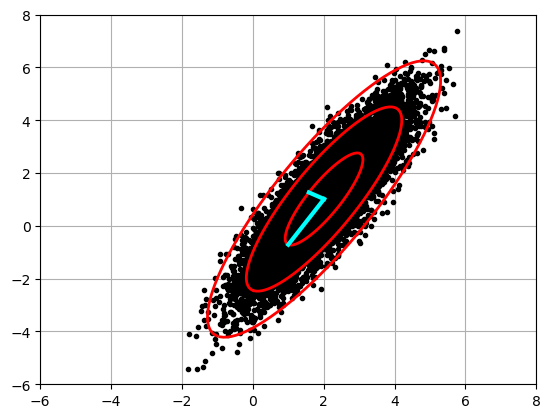

In [7]:

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.plot(X[0,:],X[1,:], '.', color='k')   # Plot data to overlay PCA
ax2.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))

theta = 2 * np.pi * np.arange(0,1,0.01)

# 1-std confidence interval
Xstd = U @ np.diag(S) @ np.array([np.cos(theta),np.sin(theta)])

ax2.plot(Xavg[0] + Xstd[0,:], Xavg[1] + Xstd[1,:],'-',color='r',linewidth=2)
ax2.plot(Xavg[0] + 2*Xstd[0,:], Xavg[1] + 2*Xstd[1,:],'-',color='r',linewidth=2)
ax2.plot(Xavg[0] + 3*Xstd[0,:], Xavg[1] + 3*Xstd[1,:],'-',color='r',linewidth=2)

# Plot principal components U[:,0]S[0] and U[:,1]S[1]
ax2.plot(np.array([Xavg[0], Xavg[0]+U[0,0]*S[0]]),
         np.array([Xavg[1], Xavg[1]+U[1,0]*S[0]]),'-',color='cyan',linewidth=3)
ax2.plot(np.array([Xavg[0], Xavg[0]+U[0,1]*S[1]]),
         np.array([Xavg[1], Xavg[1]+U[1,1]*S[1]]),'-',color='cyan',linewidth=3)

plt.show()

Now let's work on the 3D component of the surface motions recorded at a GPS data. The 3D components are the displacements in Earth, North, Vertical/Upward. the 3 fields are measured daily over years.

In [8]:
# Download data and save into a pandas.
sta="P395"
file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(file_url).text.splitlines()  # download, read text, split lines into a list
ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[];df=[]
for iday in r:  # this loops through the days of data
    crap=iday.split()
    if len(crap)<10:
      continue
    date.append((crap[1]))
    date_year.append(float(crap[2]))
    ue.append(float(crap[6])*1000)
    un.append(float(crap[7])*1000)
    uv.append(float(crap[8])*1000)
# Extract the three data dimensions
E = np.asarray(ue)# East component
N = np.asarray(un)# North component
U = np.asarray(uv)# Vertical component

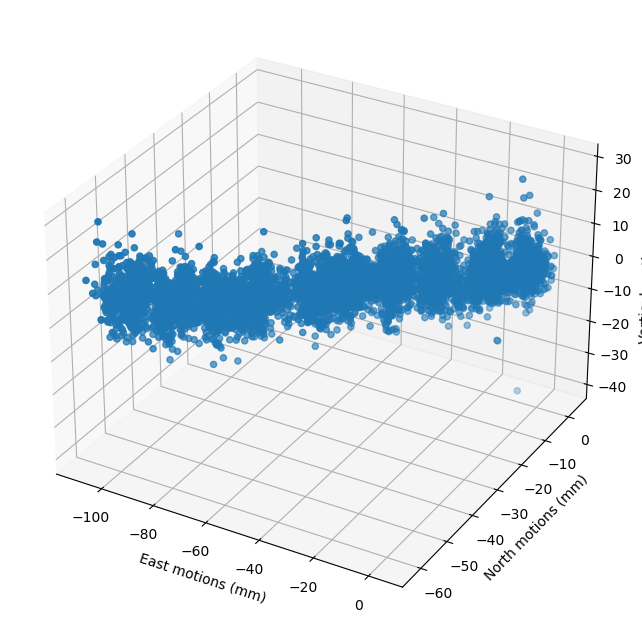

In [9]:

# plot the data
fig=plt.figure(figsize=(11,8))
ax=fig.add_subplot(projection='3d')
ax.scatter(E,N,U);ax.grid(True)
ax.set_xlabel('East motions (mm)')
ax.set_ylabel('North motions (mm)')
ax.set_zlabel('Vertical motions (mm)')
plt.show()

In [10]:
# Let's organize our GPS data in a matrix
X = np.vstack([E,N,U])
print(U.shape)
print(X.shape)
nPoints=U.shape[0]

(6086,)
(3, 6086)


In [ ]:
## Remove the mean of the data


In [ ]:
# Find principal components (SVD): 
# use the option full_matrices =0 will calculate the covariance of B

In [ ]:
# Plot the eigen spectrum

There are 3 components of motion, but the majority of the motion is explained in 1 direction.

In [ ]:
# print the first PC and provide a crude estimate of the azimuthal direction.

We will use the ``sklearn`` package. The model ``PCA`` deals with the data transformation (removing mean and standardizing), calculate the covariance, and the SVD.

**WARNING:** Numpy and sklean do not organize the data in the same dimension. 
* Using sklearn, organize the data for each field as a column.
* Using numpy, organize the data for each field as a row.


In [11]:
from sklearn.decomposition import PCA # this is the SKLEAN model
pca=PCA(n_components=3).fit(X.transpose())# retain all 3 components
print(pca)

PCA(n_components=3)


The attributes in the ``pca`` object.

* The PC axes as under ``components_``, of dimensions: n_components x n_features.
* The ``explained_variance_`` of dimensions n_components, is the amount of variance explained.
* The ``explained_variance_ratio_`` of dimension n_components: percentage of variance explained.
* The cumulative ``explained_variance_ratio_`` calculated using ``np.cumsum(pca.explained_variance_ratio_)`` will show the progressive cumulative varianced explained by a increasing number of PCs.


In [12]:
# The 3 principal axes, 
print(pca.components_)

[[-0.88025917 -0.47388028  0.0241097 ]
 [-0.04281483  0.02872139 -0.9986701 ]
 [ 0.47255761 -0.88012076 -0.04557137]]


In [13]:
# The 3 PCs' explained variance
print(pca.explained_variance_)

[1248.23439358   29.50088343    3.22684049]


Now you see that most of the variance is explained by the first PC. What azimuth is the direction of the first PC?

In [14]:

import math
azimuth=math.degrees(math.atan2(pca.components_[0][0],pca.components_[0][1]))
if azimuth <0:azimuth+=360
print("direction of the plate ",azimuth," degrees from North")

direction of the plate  241.70456397212095  degrees from North


[0.97445067 0.02303025 0.00251908]


Text(0.5, 1.0, 'Variance explained with cumulated PCs')

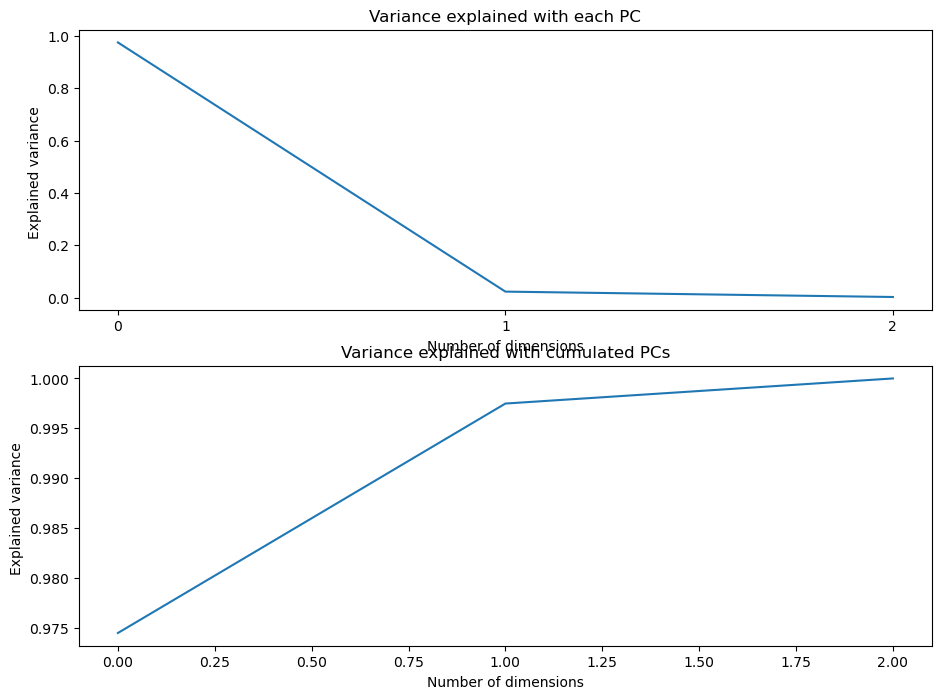

In [15]:
# The 3 PCs' explained variance ratio: how much of the variance is explained by each component
print(pca.explained_variance_ratio_)
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(pca.explained_variance_ratio_);ax[0].set_xticks(range(0,3))
ax[0].set_xlabel('Number of dimensions')
ax[0].set_ylabel('Explained variance ')
ax[0].set_title('Variance explained with each PC')
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Number of dimensions')
ax[1].set_ylabel('Explained variance ')
ax[1].set_title('Variance explained with cumulated PCs')

Now we see that 97% of the variance is explained by the first PC. We can reduce the dimension of our system by only working with a single dimension. Another way to choose the number of dimensions is to select the minimum of PCs that would explain 95% of the variance.

In [16]:
d = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95) +1
print("minimum dimension size to explain 95% of the variance ",d)

minimum dimension size to explain 95% of the variance  1


In [17]:
pca = PCA(n_components=d).fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (3, 6086)
transformed shape: (3, 1)


Inverse Transform back to the original data, but with only the first PC

(3, 6086)


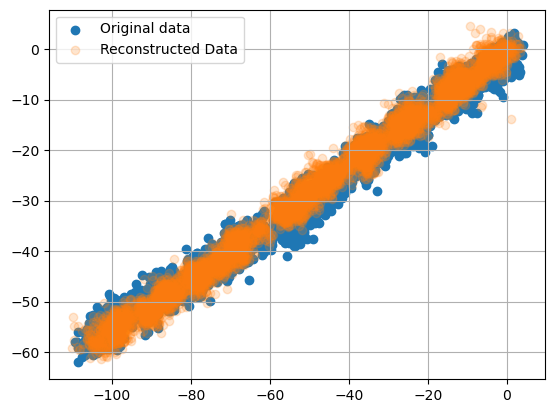

In [18]:
# Find the azimuth of the displacement vector
X_new = pca.inverse_transform(X_pca)
print(X_new.shape)
plt.scatter(X[0,:], X[1,:], alpha=1)
plt.scatter(X_new[0,:], X_new[1,:], alpha=0.2)
plt.legend(['Original data','Reconstructed Data'])
plt.grid(True)
plt.show()

*SVD* can be computationally intensive for larger dimensions. It is recommended to use a **randomized SVD** to approximate the first principal components. Scikit-learn automatically switches to randomized PCA in either the following happens: data size > 500, number of vectors is > 500 and the number of PCs selected is less than 80% of either one.


## 2. Independent Component Analysis

ICA is similar to PCA as it finds a *new basis* to represent the data.

ICA separates the multi-variate signal into additive components that are maximimally independent. These components are:
* non-Gaussian signals
* statistically independent.

The principles are:

$x = \mathbf{A}s$, where $x$ is the set of repeated observations (size $m$), $s$ are the sources (e.g., time series), $\mathbf{A}$ is the *mixing matrix*. Both $s$ and $\mathbf{A}$ are unknown. The data ought to be non-Gaussian.

ICA is used to estimate sources given noisy measurements. It is frequently used in Geodesy to isolate contributions from earthquakes and hydrology. 

In [19]:
from scipy import signal
from sklearn.decomposition import FastICA

# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# create 3 source signals
s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

# add some noise to the data
S = np.c_[s1, s2, s3] # concatenate the sources into an array
S += 0.2 * np.random.normal(size=S.shape)  # Add noise
S /= S.std(axis=0)  # Standardize data

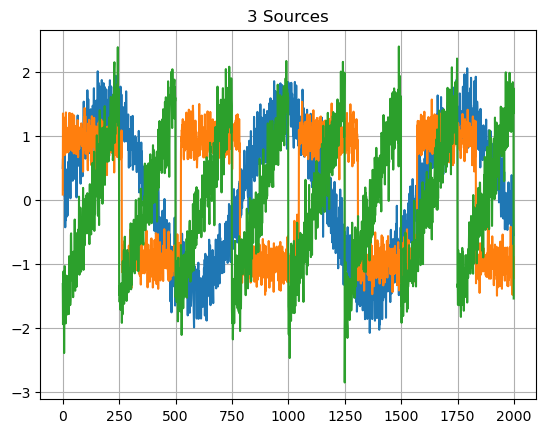

In [24]:
plt.plot(S);plt.title('3 Sources');plt.grid(True)
plt.show()

Now we will superimposed these signals to form 3 observables. The sources are only scaled to form the observations, there is not additional transformation (e.g., shifting).

[[1.  1.  1. ]
 [0.5 2.  1. ]
 [1.5 1.  2. ]]


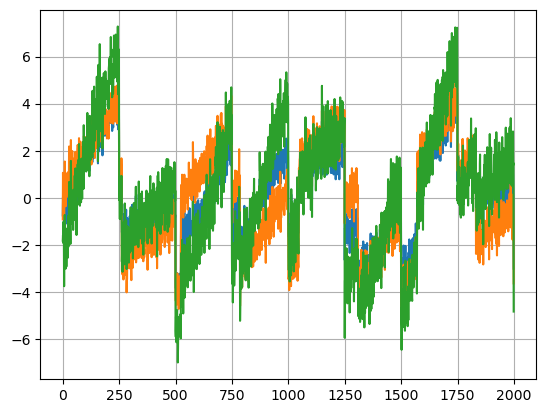

In [26]:
# Mix data: note that
# create 3 signals at 3 receivers:
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations
plt.plot(X);plt.grid(True);
print(A)
plt.show()

Now we will compute the ICA algorithm to find the mixing matrix $\mathbf{A}$ and the sources $s$:

In [30]:

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
print(A_,A)

[[-4.35828150e-15  6.04285621e-15 -1.50516855e-15]
 [ 2.89675149e-16 -4.01641168e-16  1.00041708e-16]
 [-4.89131742e-17  6.78192261e-17 -1.68925691e-17]
 ...
 [-7.34780355e-17  1.01878964e-16 -2.53762471e-17]
 [-4.87057193e-17  6.75315851e-17 -1.68209228e-17]
 [ 4.58152087e-16 -6.35238266e-16  1.58226611e-16]] [[1.  1.  1. ]
 [0.5 2.  1. ]
 [1.5 1.  2. ]]


/Users/marinedenolle/opt/miniconda3/envs/mlgeo_sk/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [ ]:
# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components


In [ ]:
plt.figure(figsize=(11,8))
models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.tight_layout()
plt.show()

## Other Techniques


1. Random Projections
https://scikit-learn.org/stable/modules/random_projection.html
2. Multidimensional Scaling
3. Isomap
4. t-Distributed stochastic neighbor embedding
5. Linear discriminant analysis